# Motion Detection Algorithm

The overall motion in the video is captured in the following code. It is done through calculating the difference in pixel values for consecutive frames and the calculating the total change. 

In [1]:
%matplotlib inline
import moviepy.editor
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def detect_motion(clip,last_fr=None):
    fr_motion=list()
    for f in clip.iter_frames(fps=10,dtype='uint32', progress_bar=1):
        if last_fr is not None:
            fr_diff = f-last_fr
            fr_motion += [fr_diff.sum()]
            del(fr_diff)
            del last_fr
        last_fr=f.copy()
    return fr_motion
    
clip=moviepy.editor.VideoFileClip('sample.mp4',target_resolution=(240,None))
fr_list=detect_motion(clip)



100%|██████████| 33721/33721 [15:19<00:00, 36.68it/s]


In [13]:
#len(fr_list)
#max_fr=max(fr_list) 
#scaling the values between o to 100
#fr_list_scaled= [i*100/max_fr for i in fr_list]

In [47]:
#fr_num= np.arange(.1, clip.duration , .1 )
#len(fr_num)

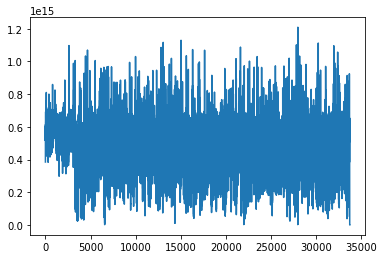

In [39]:
plt.plot(fr_list )
plt.show()

In [48]:
print(fr_list)

[384713105700430, 524084794256417, 534568809790125, 524248003198827, 593667559428394, 515932946643304, 520000280860589, 523011053067458, 606853108387063, 527507883683840, 545130134200984, 542256801278142, 591043334594105, 515043888955480, 570637944624867, 566119638925991, 615168165751777, 570526275813158, 547372107657747, 574340207187282, 619617751951358, 601703443692898, 614330647754950, 633490495985410, 664929656092012, 691966475566412, 683956362345542, 671011329862959, 647002463599949, 676968449236245, 628057363064116, 650958127259170, 617328534520778, 611040702978000, 631252818211767, 599495831049846, 668460118840396, 632884906264757, 654492885445120, 605452949783469, 590618133199282, 600775730876831, 596270310595793, 590094147288983, 601372731232175, 505942855648124, 613454473762176, 619845384633635, 584540754166031, 579464102979363, 596566663401074, 547440827233863, 595660423854025, 576449035614554, 585730460981200, 555433761363668, 622946350916775, 602467948436893, 6484670466943

In [40]:
clip.duration

3372.09

### Smoothing out the curve

Kaiser funtion of length = clip.duration and shape parameter=10 is convoluted with the density_cuts step curve to get a smooth_cut_density curve.


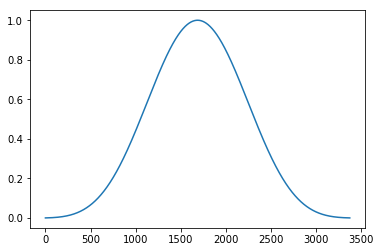

In [41]:
kaiser_func = np.kaiser(int(clip.duration),10)
plt.plot(kaiser_func)

In [42]:
motion_act_unscaled = np.convolve(kaiser_func/kaiser_func.sum(),fr_list,mode='same')


In [43]:
len(motion_act_unscaled)

33720

In [44]:
max_val=max(motion_act_unscaled) 

#scaling the values between o to 100
motion_act=motion_act_unscaled*100/max_val


In [45]:
print(motion_act)

[ 51.53400555  51.61164969  51.68929501 ...,  42.28031179  42.21848033
  42.15664244]


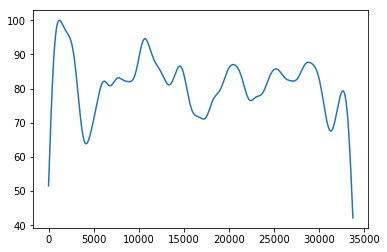

In [46]:
plt.plot(motion_act)

### Peak events

The peaks of smooth_cut_density curve were detected by finding points having both increase AND decrease. The nearby peaks were filtered out and the higher peaks were selected.

### Actual vs detected peaks

[![motion activity graph.jpg](https://s5.postimg.org/m41vr4ujr/motion_activity_graph.jpg)](https://postimg.org/image/7kuqpq1er/)

In [38]:
def get_filtered_peaks(smooth_motion_activity):
    #find peaks from the curve
    increases = np.diff(smooth_motion_activity)[:-1]>=0
    decreases = np.diff(smooth_motion_activity)[1:]<=0
    peaks_position = (increases * decreases).nonzero()[0]
    print(peaks_position)
    peaks_value = smooth_motion_activity[peaks_position]
    peaks_position = peaks_position[peaks_value>np.percentile(peaks_value,10)]
    
    #filter two close (100 frames apart) peaks
    final_peaks_position=[peaks_position[0]]
    for fr_num in peaks_position:
        if (fr_num - final_peaks_position[-1]) < 100:
            if smooth_motion_activity[fr_num] > smooth_motion_activity[final_peaks_position[-1]]:
                final_peaks_position[-1] = fr_num
        else:
            final_peaks_position.append(fr_num)

    final_times = [i/10 for i in final_peaks_position]
    return final_times

motion_peaks_times=get_filtered_peaks(motion_act)
print 'time of peaks (in secs) =', motion_peaks_times

final = moviepy.editor.concatenate([clip.subclip(max(t-5,0),min(t+5, clip.duration))
                     for t in motion_peaks_times])
#final.ipython_display()
final.to_videofile('summary_by_motion_detection.mp4')

[ 1200  6171  7749  7751  8941 10682 14538 20467 25194 28788 32612]
time of peaks (in secs) = [120, 617, 775, 1068, 1453, 2046, 2519, 2878]
[MoviePy] >>>> Building video summary_by_motion_detection.mp4
[MoviePy] Writing audio in summary_by_motion_detectionTEMP_MPY_wvf_snd.mp3


100%|██████████| 1764/1764 [00:03<00:00, 470.32it/s]

[MoviePy] Done.
[MoviePy] Writing video summary_by_motion_detection.mp4



100%|██████████| 4796/4796 [00:40<00:00, 130.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: summary_by_motion_detection.mp4 

